In [5]:
%load_ext autoreload
%load_ext tensorboard

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [8]:
import os
import datetime
import pickle
import sys
sys.path.append('..')

import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

from lib.cube import Cube
from lib.solver import CubeSolver
from lib.models import CNN
from lib.utils import linear_decay_constant, exponential_decay, constant_rate


%autoreload

In [3]:
now = datetime.datetime.now().strftime("%Y%d%d%H%M%S")
session_name = 'base_model_v2_{}'.format(now)


config = {}

config['model_params'] = {'embed_dim':100,
                          'num_filters':50,
                          'num_conv_layers':3,
                          'kernel_size':2,
                          'regularization_constant':.5,
                          'num_dense_layers':3,
                           'dense_activation':'elu'}

config['training_params'] = {'exploration_rate_func':linear_decay_constant,
                             'num_shuffles':3,
                             'num_episodes':5000,
                             'max_time_steps':5,
                             'epsilon':None,
                             'decay_constant':0,
                             'end_state_reward':1,
                             'replay_buffer_capacity':128,
                             'learning_rate':.0001,
                             'clipnorm':0,
                             'batch_size':16,
                             'discount_factor':.9,
                             'validation_count':100,
                             'train_log_name':session_name,
                             'logging':False,
                             'stop_on_solve':True}

In [4]:
tuning_log_dir='../logs/hptuning/'
config_save_path = os.path.join(tuning_log_dir,
                                'configs',
                                session_name + '.pickle')

with open(config_save_path ,'wb') as f:
    pickle.dump(config, f)




session_num = 0
validation_count = 100

for reg_constant in HP_REG_CONSTANT.domain.values:
    for exp_constant in HP_EXP_CONSTANT.domain.values:
        for buffer in HP_BUFFER.domain.values:
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            hparams = {'regularization_constant': reg_constant,
                       'epsilon':exp_constant,
                       'replay_buffer_capacity':buffer}
            for hyper_parameter in hparams:
                if hyper_parameter in config['model_params']:
                    config['model_params'][hyper_parameter] = hparams[hyper_parameter]
                elif hyper_parameter in config['training_params']:
                    config['training_params'][hyper_parameter] = hparams[hyper_parameter]

            tuning_log_session_dir = os.path.join(tuning_log_dir,session_name,str(session_num))
            with tf.summary.create_file_writer(tuning_log_session_dir).as_default():
                hp.hparams(hparams)
                solver = CubeSolver()
                solver.model = CNN(**config['model_params'])
                solver.train(**config['training_params'])

                solve_count = 0
                for val_trial in range(validation_count):
                    val_trial_cube = Cube()
                    val_trial_cube.shuffle(config['training_params']['num_shuffles'])
                    solve_count += solver.solve(val_trial_cube, config['training_params']['max_time_steps'])[0]
                    val_acc = float(solve_count) / float(validation_count)
                tf.summary.scalar('accuracy', val_acc, step=1)
            session_num+=1




--- Starting trial: run-0
--- Starting trial: run-1
--- Starting trial: run-2


(array([3270.,    0., 3395.,    0.,    0.,    0.,    0.,    0.,    0.,
        3335.]),
 array([0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21, 0.23, 0.25]),
 <a list of 10 Patch objects>)

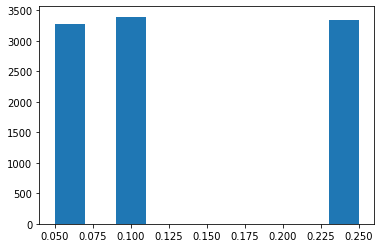

In [31]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
HP_EXP_CONSTANT = hp.HParam('epsilon', hp.Discrete([0.05, .1,.25]))
choice = []
for i in range(10000):
    choice.append(np.random.choice( HP_EXP_CONSTANT.domain.values))
plt.hist(choice)

In [59]:

HP_REG_CONSTANT = hp.HParam('regularization_constant', hp.Discrete([0.5]))
HP_EXP_CONSTANT = hp.HParam('epsilon', hp.Discrete([0.05, .1,.25]))
HP_BUFFER = hp.HParam('replay_buffer_capacity', hp.Discrete([128]))

hparams = [HP_REG_CONSTANT, HP_EXP_CONSTANT, HP_BUFFER]
search_params = {hparam.name:np.random.choice(hparam.domain.values) for hparam in hparams}
search_params

{'regularization_constant': 0.5, 'epsilon': 0.1, 'replay_buffer_capacity': 128}

In [67]:
[type(v) for v in search_params.values()]

[numpy.float64, numpy.float64, int]

In [65]:
np.int64

numpy.int64